In [1]:
# %matplotlib widget

## Hyperfine effects in $\text{H}_2\text{S}$.

The hyperfine interaction is represented by spin-rotation coupling.

In [2]:
import itertools

import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from py3nj import wigner3j
from rovib.hyperfine_xy2 import dipole_xy2, spin_me_xy2, spinrot_xy2
from rovib.symtop import symtop_on_grid_split_angles
from hdfdict import hdfdict
from scipy import constants, stats
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix
from scipy.spatial.transform import Rotation
import json


KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

DEBYE_TO_AU = (
    1e-21
    / constants.value("speed of light in vacuum")
    / constants.value("elementary charge")
    / constants.value("Bohr radius")
)

# conversion to inverse centimeters for a quantity 'field * dipole',
# where field is in Volts/meter and dipole is in Debye
DEBYE_X_VM_TO_INVCM = (
    constants.value("atomic unit of electric dipole mom.")
    / (constants.value("Planck constant") * constants.value("speed of light in vacuum"))
    / 1e2
    * DEBYE_TO_AU
)

# spins of Y1 and Y2 in XY2-type molecule
SPIN1 = 0.5
SPIN2 = 0.5

Load rovibrational energies and matrix elements of laboratory-frame spin-rotation and electric dipole operators, and molecular-frame valence coordinates, from files. 

The matrix elements are precomputed for selected states using `h2s_cart_me.py`.
For example, files `h2s_enr_1000_j40_j60_pmax24.h5` and `h2s_me_1000_j...h5` contain energies and matrix elements for the 1000 lowest rovibrational states for each $J=40..60$, calculated using vibrational basis truncated at $P_\text{max}=24$. 

In [3]:
j_list = (60,)
tol = 1e-12

print(f"read energies and quanta for J in {j_list}")
with h5py.File(
    f"/Volumes/Extreme SSD/Maxwell/gpfs_data/rotational_clusters/h2s_enr_1000_j40_j60_pmax24.h5",
    "r",
) as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)
    coefs = hdfdict.load(h5.require_group("coefficients"), False)
    vind = hdfdict.load(h5.require_group("vib-indices"), False)
    rind = hdfdict.load(h5.require_group("rot-indices"), False)

rovib_enr = {
    int(j): {sym: enr_sym for sym, enr_sym in enr_j.items()} for j, enr_j in enr.items()
}

rovib_coefs = {
    int(j): {sym: coefs_sym for sym, coefs_sym in coefs_j.items()}
    for j, coefs_j in coefs.items()
}

rovib_vind = {
    int(j): {sym: vind_sym for sym, vind_sym in vind_j.items()}
    for j, vind_j in vind.items()
}

rovib_rind = {
    int(j): {sym: rind_sym for sym, rind_sym in rind_j.items()}
    for j, rind_j in rind.items()
}

rovib_qua = {
    int(j): {
        sym: np.array(
            [[i] + elem[0].decode("utf-8").split(",") for i, elem in enumerate(qua_sym)]
        )
        for sym, qua_sym in qua_j.items()
    }
    for j, qua_j in qua.items()
}

print(f"read spin-rotation and dipole matrix elements for J in {j_list}")

rovib_sr1 = {}
rovib_sr2 = {}
rovib_dipole = {}
rovib_coord = {}

for j1 in j_list:
    for j2 in j_list:
        try:
            filename = f"/Volumes/Extreme SSD/Maxwell/gpfs_data/rotational_clusters/h2s_me_1000_j{j1}_j{j2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(j1, j2)}, |dJ| = {abs(j1-j2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dipole = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dipole = {}
                try:
                    coord = hdfdict.load(h5.require_group("coordinate"), False)
                except ValueError:
                    coord = {}

                rovib_sr1[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr1.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_sr2[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in sr2.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_dipole[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in dipole.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

                rovib_coord[(j1, j2)] = {
                    (sym1, sym2): me
                    for sym1, me_sym1 in coord.items()
                    for sym2, me in me_sym1.items()
                    if np.any(np.abs(me) > tol)
                }

        except FileNotFoundError:
            pass

read energies and quanta for J in (60,)
read spin-rotation and dipole matrix elements for J in (60,)
read (J1, J2) = (60, 60), |dJ| = 0, from file /Volumes/Extreme SSD/Maxwell/gpfs_data/rotational_clusters/h2s_me_1000_j60_j60.h5


For analysis, determine largest spin-rotation coupling constant $M_{\omega=2,n}^{(J',l',J,l)}$ for selected $J$ quanta and symmetries

In [4]:
selected_states = []
for j in j_list:
    sym1 = "A1"
    sym2 = "B2"
    me = rovib_sr1[(j, j)][(sym1, sym2)][:, :, -1]  # omega = 2
    me2 = rovib_sr2[(j, j)][(sym1, sym2)][:, :, -1]
    ind = np.argsort(np.abs(me), axis=None)[-3:]  # largest 3 elements
    i1, i2 = np.unravel_index(ind, me.shape)
    ind = list(zip(i1, i2))
    for i1, i2 in sorted(ind, key=lambda x: x[0]):
        e1 = rovib_enr[j][sym1][i1]
        e2 = rovib_enr[j][sym2][i2]
        selected_states.append([j, int(i1), int(i2), sym1, sym2, e1, e2, np.real(me[i1, i2])])
        print(j, i1, i2, sym1, e1, sym2, e2, me[i1, i2])

with open("rovib_states_largest_sr.json", "w") as fl:
    json.dump(selected_states, fl)

60 604 603 A1 32309.79530926803 B2 32309.795309318873 (2.0503955864506227+0j)
60 915 910 A1 33735.33993841213 B2 33735.33993650102 (2.027640910428618+0j)
60 964 960 A1 33933.658907346115 B2 33933.65885670377 (-2.0506160079903353+0j)


If you look at rotational densities for states corresponding to largest spin-rotation coupling constant (in 'etc/density_assignment/pmax24'), you will notice that the lowest energy states correspond to cluster states (or pre-cluster states that lie below the true cluster states). The hiher energy states are perhaps cluster states in the excited vibrational states.

### Calculate hyperfine states for selected values of $F$ (quantum number of the total spin-rotational angular momentum)

In [5]:
f_list = (60.0, )

hyper_qua = {}
hyper_qua_block = {}
hyper_enr = {}
hyper_vec = {}
hyper_ham = {}

for f in f_list:

    print(f"solve for F = {f}")

    ham_sr, hyper_qua[f], hyper_qua_block[f] = spinrot_xy2(
        f,
        rovib_enr,
        rovib_qua,
        rovib_sr1,
        rovib_sr2,
        spin_states=((0, "B2"), (1, "A1")),
        spins=(SPIN1, SPIN2),
    )

    hyper_enr[f] = {}
    hyper_vec[f] = {}
    hyper_ham[f] = {}

    for sym, qua_sym in hyper_qua_block[f].items():
        h0 = np.diag(
            np.concatenate(
                np.array([rovib_enr[int(j)][rov_sym] for (j, rov_sym, *_) in qua_sym]),
                axis=-1,
            )
        )

        h = h0 + ham_sr[sym]
        enr, vec = np.linalg.eigh(h)
        hyper_enr[f][sym] = enr
        hyper_vec[f][sym] = vec
        hyper_ham[f][sym] = ham_sr[sym]

solve for F = 60.0


Read the indices of rotational cluster states in the vibrational ground state. These states were previously identified using the `h2s_cluster.ipynb` notebook, with their indices stored in files such as `h2s_cluster_states_id_pmax24.txt`.

In [6]:
min_j = 40
max_j = 60
cluster_state_ind = {}
with open(f"h2s_cluster_states_id_pmax24.txt", "r", encoding="utf-8") as fl:
    for line in fl:
        w = line.split()
        j = [int(w[0 + i * 12]) for i in range(4)]
        id = [int(w[1 + i * 12]) for i in range(4)]
        sym = [w[3 + i * 12] for i in range(4)]
        assert all(j[0] == elem for elem in j), f"Not all J quanta are equal: {j}"
        j_ = j[0]

        if j_ >= min_j and j_ <= max_j:
            cluster_state_ind[j_] = {}
            for sym_, id_ in zip(sym, id):
                try:
                    cluster_state_ind[j_][sym_].append(id_)
                except KeyError:
                    cluster_state_ind[j_][sym_] = [id_]
            cluster_state_ind[j_] = dict(sorted(cluster_state_ind[j_].items()))
            print(f"J = {j_}, cluster-state IDs: {cluster_state_ind[j_]}")

J = 40, cluster-state IDs: {'A1': [106], 'A2': [97], 'B1': [97], 'B2': [104]}
J = 41, cluster-state IDs: {'A1': [101], 'A2': [120], 'B1': [120], 'B2': [103]}
J = 42, cluster-state IDs: {'A1': [130], 'A2': [118], 'B1': [117], 'B2': [129]}
J = 43, cluster-state IDs: {'A1': [126], 'A2': [145], 'B1': [146], 'B2': [127]}
J = 44, cluster-state IDs: {'A1': [157], 'A2': [145], 'B1': [144], 'B2': [156]}
J = 45, cluster-state IDs: {'A1': [153], 'A2': [173], 'B1': [174], 'B2': [154]}
J = 46, cluster-state IDs: {'A1': [193], 'A2': [170], 'B1': [169], 'B2': [192]}
J = 47, cluster-state IDs: {'A1': [188], 'A2': [208], 'B1': [210], 'B2': [189]}
J = 48, cluster-state IDs: {'A1': [230], 'A2': [205], 'B1': [205], 'B2': [228]}
J = 49, cluster-state IDs: {'A1': [224], 'A2': [248], 'B1': [249], 'B2': [225]}
J = 50, cluster-state IDs: {'A1': [280], 'A2': [242], 'B1': [242], 'B2': [277]}
J = 51, cluster-state IDs: {'A1': [267], 'A2': [299], 'B1': [299], 'B2': [270]}
J = 52, cluster-state IDs: {'A1': [327], '

Identify rotational cluster states among the hyperfine states. List the hyperfine states with the largest mixing of rovibrational states; note that the lowest-energy states with the highest degree of mixing correspond to rotational cluster states in the vibrational ground state. States with high mixing and higher energies represent cluster states in vibrationally excited states.

In [7]:
hyper_state_ind = {
    f: {sym: [] for sym in val.keys()} for f, val in hyper_qua.items()
}

for f, v_f in hyper_vec.items():
    for sym, v_sym in v_f.items():
        enr = hyper_enr[f][sym]
        qua = hyper_qua[f][sym]
        hyp_id = np.arange(len(enr))
        rov_j = np.array([int(q[0]) for q in qua])
        rov_id = np.array([int(q[4]) for q in qua])
        rov_sym = np.array([q[1] for q in qua])

        c2 = np.abs(v_sym) ** 2
        ind = np.argmax(c2, axis=0)
        c2_max = np.max(c2, axis=0)
        qua = qua[ind]
        rov_j = rov_j[ind]
        rov_id = rov_id[ind]
        rov_sym = rov_sym[ind]

        c2_sort_ind = np.argsort(c2_max)
        enr = enr[c2_sort_ind]
        c2_max = c2_max[c2_sort_ind]
        hyp_id = hyp_id[c2_sort_ind]
        qua = qua[c2_sort_ind]
        rov_j = rov_j[c2_sort_ind]
        rov_id = rov_id[c2_sort_ind]
        rov_sym = rov_sym[c2_sort_ind]

        no_cluster = 0
        for i, (c2, hy_id, e, q, j, rv_id, rv_sym) in enumerate(
            zip(c2_max, hyp_id, enr, qua, rov_j, rov_id, rov_sym)
        ):
            rov_e = rovib_enr[j][rv_sym][rv_id]
            shift = (e - rov_e) / KHZ_TO_INVCM
            if rv_id == cluster_state_ind[j][rv_sym][0]:
                hyper_state_ind[f][sym].append((hy_id, shift, rov_e))
                mark = "*"
                no_cluster += 1
            else:
                mark = ""
            print(f, sym, hy_id, e, c2, q, shift, mark)
            if no_cluster == 2:  # two states for B1 and two for B2 symmetries
                print("")
                break

60.0 B1 1802 32309.795271860992 0.5038323099737484 ['60' 'B1' '1' 'A1' '544' 'B1' '60' '0' '2' '1' 'B2' '9' '1' 'A2'] -1121.1944853114146 *
60.0 B1 1803 32309.795346180494 0.5038323099737503 ['60' 'A2' '0' 'B2' '546' 'A2' '60' '0' '2' '1' 'B2' '14' '1' 'B1'] 1105.4818730031643 *

60.0 B2 1851 32309.79527187199 0.5031836937440078 ['60' 'B2' '1' 'A1' '603' 'B2' '60' '1' '1' '1' 'A1' '55' '0' 'B2'] -1122.6293294650598 *
60.0 B2 1852 32309.79534619082 0.5031836937440116 ['60' 'A1' '0' 'B2' '604' 'A1' '60' '1' '1' '1' 'A1' '42' '0' 'A1'] 1106.9173715399745 *



### Analyse wavefunctions for rotational cluster states in hyperfine basis and plot reduced rotational probability density and spin-density

In [121]:
f = 60.0
m_f = f

Print leading wavefunction contributions of rovibrational states to selected hyperfine rotational cluster states.

In [9]:
vec_thresh = 1e-6

for sym in hyper_state_ind[f].keys():

    # indices of hyperfine cluster states
    ind = [i for (i, *_) in hyper_state_ind[f][sym]]

    # indices of rovibrational states with significant contributions to hyperfine cluster states
    nz_vec_ind = np.unique(
        np.hstack(
            [np.where(np.abs(hyper_vec[f][sym][:, i]) > vec_thresh)[0] for i in ind]
        )
    )

    # hyperfine energies
    enr = [hyper_enr[f][sym][i] for i in ind]

    # largest eigenvector contributions from rovibrational states into selected hyperfine cluster states
    vec = np.array([hyper_vec[f][sym][nz_vec_ind, i] for i in ind])

    # assignment of largest eigenvector contributions
    qua = hyper_qua[f][sym][nz_vec_ind]

    print(f"\nF = {f}, sym = {sym}")
    print("leading quanta")
    print(qua)
    print("cluster states and leading wavefunction contibutions")
    for i, (e, v) in enumerate(zip(enr, vec.T)):
        print(i, ind[i], e, v)

    print("SR Hamiltonian")
    for i, i1 in enumerate(nz_vec_ind):
        for j, i2 in enumerate(nz_vec_ind):
            print(i, j, hyper_ham[f][sym][i1, i2])


F = 60.0, sym = B1
leading quanta
[['60' 'A2' '0' 'B2' '546' 'A2' '60' '0' '2' '1' 'B2' '14' '1' 'B1']
 ['60' 'B1' '1' 'A1' '544' 'B1' '60' '0' '2' '1' 'B2' '9' '1' 'A2']]
cluster states and leading wavefunction contibutions
0 1802 32309.795271860992 [ 0.70439172+0.j -0.70981146+0.j]
1 1803 32309.795346180494 [-0.70981146+0.j -0.70439172+0.j]
SR Hamiltonian
0 0 0j
0 1 (3.715865968494712e-05+0j)
1 0 (3.7158659684947137e-05+0j)
1 1 (-5.240838558223315e-07+0j)

F = 60.0, sym = B2
leading quanta
[['60' 'A1' '0' 'B2' '604' 'A1' '60' '1' '1' '1' 'A1' '42' '0' 'A1']
 ['60' 'B2' '1' 'A1' '603' 'B2' '60' '1' '1' '1' 'A1' '55' '0' 'B2']]
cluster states and leading wavefunction contibutions
0 1851 32309.79527187199 [ 0.70485197+0.j -0.70935442+0.j]
1 1852 32309.79534619082 [0.70935442+0.j 0.70485197+0.j]
SR Hamiltonian
0 0 0j
0 1 (-3.715866064501493e-05+0j)
1 0 (-3.715866064501493e-05+0j)
1 1 (-5.240838558788894e-07+0j)


In [10]:
def psi_on_grid(j: int, vib_ind, rot_ind, coefs, alpha, beta, gamma):
    """Computes rovibrational function for selected states on grid of Euler angles"""
    rot_k, rot_m, rot_mu, k_list, jktau_list = symtop_on_grid_split_angles(
        j, alpha, beta, gamma
    )
    rot_k = rot_k[rot_ind]
    vib_ind_unique = list(set(vib_ind))
    v_ind = [np.where(vib_ind == ind)[0] for ind in vib_ind_unique]
    unique_vec = np.zeros((len(vib_ind), len(vib_ind_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1
    rot_kv = np.einsum(
        "i...,img,iv->mvg...", coefs, rot_k, unique_vec, optimize="optimal"
    )
    return rot_kv, rot_m, rot_mu, enr, vib_ind_unique


def monte_carlo_distr(npoints, alpha, beta, gamma, dens, xyz):
    """Monte-Carlo sampling of Cartesian coordiantes based on density `dens[alpha, beta, gamma]`"""
    fdens = RegularGridInterpolator((alpha, beta, gamma), dens)
    points = np.random.uniform(
        low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
    )
    w = fdens(points)
    signs = np.sign(w)
    abs_w = np.abs(w) / np.max(np.abs(dens))
    eta = np.random.uniform(0.0, 1.0, size=len(w))
    ind = np.where(abs_w > eta)
    points = points[ind]
    signs = signs[ind]
    rotmat = Rotation.from_euler("ZYZ", points).as_matrix()
    xyz_sample = np.dot(rotmat, xyz)
    kernel = stats.gaussian_kde(xyz_sample.T)
    weights = kernel(xyz_sample.T)
    return xyz_sample, weights, signs

Specify grids for Euler angles and coordinates of atoms in the molecular frame.

In [11]:
# grid of Euler angles

npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)

# reference Cartesian coordinates of atoms (from h2s_rovib.ipynb [3])

atom_label = ("S", "H1", "H2")
atom_xyz = np.array(
    [
        [-5.48977100e-02, 0.00000000e00, 1.12725516e-12],
        [8.70782813e-01, 0.00000000e00, 9.63109860e-01],
        [8.70782813e-01, 0.00000000e00, -9.63109860e-01],
    ]
)
atom_xyz = atom_xyz / np.linalg.norm(atom_xyz, axis=-1)[:, None]
print(atom_xyz)

[[-1.00000000e+00  0.00000000e+00  2.05337374e-11]
 [ 6.70658210e-01  0.00000000e+00  7.41766517e-01]
 [ 6.70658210e-01  0.00000000e+00 -7.41766517e-01]]


Compute rotational probability density for selected hyperfine states.

In [12]:
vec_thresh = 1e-6

dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]
nz_vec_ind = {}  # nz_vec_ind[sym]

for sym in hyper_state_ind[f].keys():

    # indices of hyperfine-basis states with significant contributions
    # to selected hyperfine states
    nz_vec_ind[sym] = np.unique(
        np.hstack(
            [
                np.where(np.abs(hyper_vec[f][sym][:, i]) > vec_thresh)[0]
                for (i, *_) in hyper_state_ind[f][sym]
            ]
        )
    )

    print(
        f"Rovibrational wavefunctions for F = {f}, sym = {sym}, "
        + f"no. states = {len(nz_vec_ind[sym])}, state indices = {nz_vec_ind[sym]}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for hy_state_ind in nz_vec_ind[sym]:
        rov_qua = hyper_qua[f][sym][hy_state_ind]
        j = int(rov_qua[0])
        rov_sym = rov_qua[1]
        i = int(rov_qua[2])
        rv_state_ind = int(rov_qua[4])

        mi = np.linspace(-i, i, int(2 * i) + 1)
        mj = np.arange(-j, j + 1)
        mij = np.concatenate(
            (
                mi[:, None, None].repeat(len(mj), axis=1),
                mj[None, :, None].repeat(len(mi), axis=0),
            ),
            axis=-1,
        ).reshape(-1, 2)
        n = len(mij)
        two_mi, two_mj = mij.T * 2

        threej = wigner3j(
            [int(f * 2)] * n,
            [i * 2] * n,
            [j * 2] * n,
            [-int(m_f * 2)] * n,
            two_mi.astype(int),
            two_mj.astype(int),
            ignore_invalid=True,
        ).reshape(len(mi), len(mj))

        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rv_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"Hyperfine densities for F = {f}, (sym1, sym2) = {(sym1, sym2)}")

        # compute density in the product basis of rovibrational and spin functions

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints), dtype=np.complex128
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_ind1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_ind2, i2) in enumerate(psi2):
                if i1 != i2:
                    continue
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"different lists of vibrational quanta for basis states (ibra, iket) = {(i1, i2)},"
                    + f"diff: {diff}"
                )

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vi1]),
                    rot_kv2[:, vi2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mjg->ijg", np.conj(rot_m1), rot_m2, optimize="optimal"
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija,ijb,b->abg",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        vec1 = np.array(
            [
                hyper_vec[f][sym1][nz_vec_ind[sym1], i]
                for (i, *_) in hyper_state_ind[f][sym1]
            ]
        )
        vec2 = np.array(
            [
                hyper_vec[f][sym2][nz_vec_ind[sym2], i]
                for (i, *_) in hyper_state_ind[f][sym2]
            ]
        )

        dens[(sym1, sym2)] = np.einsum(
            "ki,ij...,lj->kl...", np.conj(vec1), prim_dens, vec2, optimize="optimal"
        )

Rovibrational wavefunctions for F = 60.0, sym = B1, no. states = 2, state indices = [1546 2544]
Rovibrational wavefunctions for F = 60.0, sym = B2, no. states = 2, state indices = [1604 2603]
Hyperfine densities for F = 60.0, (sym1, sym2) = ('B1', 'B1')
Hyperfine densities for F = 60.0, (sym1, sym2) = ('B1', 'B2')
Hyperfine densities for F = 60.0, (sym1, sym2) = ('B2', 'B1')
Hyperfine densities for F = 60.0, (sym1, sym2) = ('B2', 'B2')


Plot rotational densities for hyperfine cluster states.

Plot rotational density for state symmetry B1
state index: 0, energy: 32309.795271860992
state index: 1, energy: 32309.795346180494
Plot rotational density for state symmetry B2
state index: 0, energy: 32309.79527187199
state index: 1, energy: 32309.79534619082


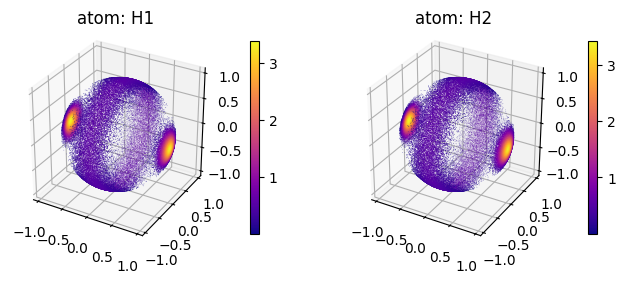

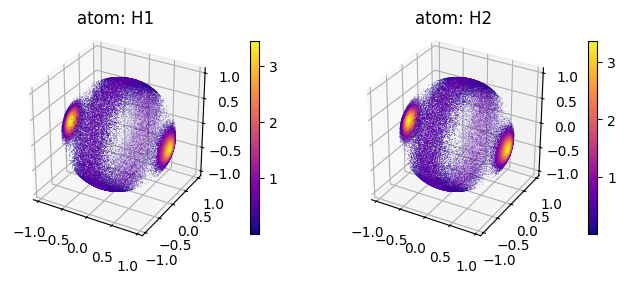

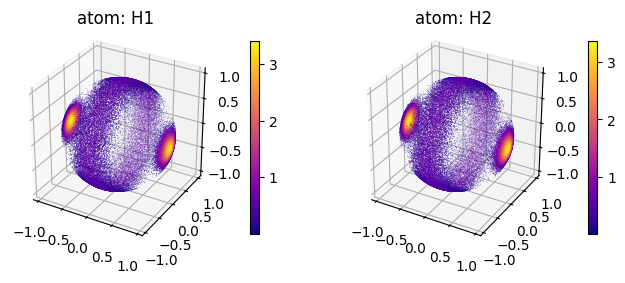

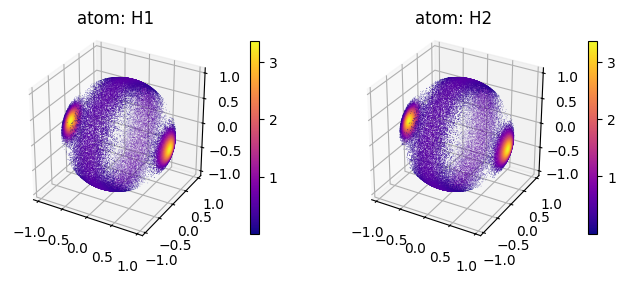

In [13]:
for sym in ("B1", "B2"):
    print(f"Plot rotational density for state symmetry {sym}")

    for istate in range(len(dens[sym, sym])):
        ind, *_ = hyper_state_ind[f][sym][istate]
        e = hyper_enr[f][sym][ind]
        print(f"state index: {istate}, energy: {e}")

        fig = plt.figure(figsize=(8, 5))
        axs = [
            fig.add_subplot(1, 2, 1, projection="3d"),
            fig.add_subplot(1, 2, 2, projection="3d"),
        ]
        for ax in axs:
            ax.set_box_aspect(aspect=(1, 1, 1))
            ax.axes.set_xlim3d(left=-1.1, right=1.1)
            ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
            ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

        for i, (xyz, ax) in enumerate(zip(atom_xyz[1:], axs)): # skip S atom
            d = dens[(sym, sym)][istate, istate]
            xyz_samples, weights, signs = monte_carlo_distr(
                2000000, alpha, beta, gamma, d, xyz
            )

            x, y, z = xyz_samples.T
            sc = ax.scatter(
                z,
                x,
                y,
                c=weights,
                s=1,
                edgecolor="none",
                marker=".",
                cmap="plasma",
                norm=mcolors.Normalize(vmin=np.min(weights), vmax=np.max(weights)),
            )
            ax.view_init(elev=30, azim=-60)

            cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
            ax.set_title(f"atom: {atom_label[i+1]}")

        plt.savefig(f"h2s_mc_dens_f{f}_m{m_f}_sym{sym}_ind{istate}.png", dpi=300)
        # plt.show()

Compute rotational spin-density for selected hyperfine states.

In [13]:
vec_thresh = 1e-6

spin_dens = {}  # dens[(sym1, sym2)]

# precompute wavefunctions and contract them with three-j symbols

psi_threej = {}  # psi_threej[sym]
nz_vec_ind = {}  # nz_vec_ind[sym]

for sym in hyper_state_ind[f].keys():

    # indices of hyperfine basis functions with significant
    # contributions to selected hyperfine states
    nz_vec_ind[sym] = np.unique(
        np.hstack(
            [
                np.where(np.abs(hyper_vec[f][sym][:, i]) > vec_thresh)[0]
                for (i, *_) in hyper_state_ind[f][sym]
            ]
        )
    )

    print(
        f"Compute rovibrational wavefunctions for F = {f}, symmetry = {sym}, "
        + f"no. states = {len(nz_vec_ind[sym])}, state indices = {nz_vec_ind[sym]}"
    )

    p = f + m_f
    ip = int(p)
    assert abs(p - ip) < 1e-16, f"F + m_f: {f} + {m_f} = {p} is not an integer number"
    prefac = (-1) ** p * np.sqrt(2 * f + 1)

    psi = []

    for hy_state_ind in nz_vec_ind[sym]:
        rov_qua = hyper_qua[f][sym][hy_state_ind]
        j = int(rov_qua[0])
        rov_sym = rov_qua[1]
        i = int(rov_qua[2])
        rv_state_ind = int(rov_qua[4])

        mi = np.linspace(-i, i, int(2 * i) + 1)
        mj = np.arange(-j, j + 1)
        mij = np.concatenate(
            (
                mi[:, None, None].repeat(len(mj), axis=1),
                mj[None, :, None].repeat(len(mi), axis=0),
            ),
            axis=-1,
        ).reshape(-1, 2)
        n = len(mij)
        two_mi, two_mj = mij.T * 2

        threej = wigner3j(
            [int(f * 2)] * n,
            [i * 2] * n,
            [j * 2] * n,
            [-int(m_f * 2)] * n,
            two_mi.astype(int),
            two_mj.astype(int),
            ignore_invalid=True,
        ).reshape(len(mi), len(mj))

        rot_kv, rot_m, rot_mu, enr, vib_ind = psi_on_grid(
            j,
            rovib_vind[j][rov_sym],
            rovib_rind[j][rov_sym],
            rovib_coefs[j][rov_sym][:, rv_state_ind],
            alpha,
            beta,
            gamma,
        )
        rot_m = np.einsum("nm,mig->nig", threej, rot_m, optimize="optimal") * prefac
        psi.append((rot_kv, rot_m, rot_mu, vib_ind, i))

    psi_threej[sym] = psi

# compute densities

for sym1, psi1 in psi_threej.items():
    for sym2, psi2 in psi_threej.items():

        print(f"Compute densities for F = {f}, (symmetry1, symmetry2) = {(sym1, sym2)}")

        # compute density matrix

        prim_dens = np.zeros(
            (len(psi1), len(psi2), npoints, npoints, npoints, 3, 2), dtype=np.complex128
        )

        for ibra, (rot_kv1, rot_m1, rot_mu1, vib_ind1, i1) in enumerate(psi1):
            for iket, (rot_kv2, rot_m2, rot_mu2, vib_ind2, i2) in enumerate(psi2):
                vib_ind12 = list(set(vib_ind1) & set(vib_ind2))
                vi1 = [vib_ind1.index(v) for v in vib_ind12]
                vi2 = [vib_ind2.index(v) for v in vib_ind12]
                diff = list(set(vib_ind1) - set(vib_ind2))
                assert len(diff) == 0, (
                    f"Different lists of vibrational quanta for basis states (ibra, iket) = {(i1, i2)},"
                    + f"differences in the following quanta: {diff}"
                )

                spin_me = spin_me_xy2(i1, i2, SPIN1, SPIN2)

                den_kv = np.einsum(
                    "ivg,jvg->ijg",
                    np.conj(rot_kv1[:, vi1]),
                    rot_kv2[:, vi2],
                    optimize="optimal",
                )
                den_m = np.einsum(
                    "mig,mn...,njg->ijg...",
                    np.conj(rot_m1),
                    spin_me,
                    rot_m2,
                    optimize="optimal",
                )
                den_mu = np.einsum(
                    "ig,jg->ijg", np.conj(rot_mu1), rot_mu2, optimize="optimal"
                )
                prim_dens[ibra, iket] = np.einsum(
                    "ijg,ija...,ijb,b->abg...",
                    den_kv,
                    den_m,
                    den_mu,
                    np.sin(beta),
                    optimize="optimal",
                )

        # transform density to basis of hyperfine states

        vec1 = np.array(
            [
                hyper_vec[f][sym1][nz_vec_ind[sym1], i]
                for (i, *_) in hyper_state_ind[f][sym1]
            ]
        )
        vec2 = np.array(
            [
                hyper_vec[f][sym2][nz_vec_ind[sym2], i]
                for (i, *_) in hyper_state_ind[f][sym2]
            ]
        )

        spin_dens[(sym1, sym2)] = np.einsum(
            "ki,ij...,lj->kl...", np.conj(vec1), prim_dens, vec2, optimize="optimal"
        )

Compute rovibrational wavefunctions for F = 60.0, symmetry = B1, no. states = 2, state indices = [1546 2544]
Compute rovibrational wavefunctions for F = 60.0, symmetry = B2, no. states = 2, state indices = [1604 2603]
Compute densities for F = 60.0, (symmetry1, symmetry2) = ('B1', 'B1')
Compute densities for F = 60.0, (symmetry1, symmetry2) = ('B1', 'B2')
Compute densities for F = 60.0, (symmetry1, symmetry2) = ('B2', 'B1')
Compute densities for F = 60.0, (symmetry1, symmetry2) = ('B2', 'B2')


Plot rotational spin-densities for cluster states.

Plot rotational spin-density for state symmetry B1
state index: 0, energy: 32309.795271860992
state index: 1, energy: 32309.795346180494
Plot rotational spin-density for state symmetry B2
state index: 0, energy: 32309.79527187199
state index: 1, energy: 32309.79534619082


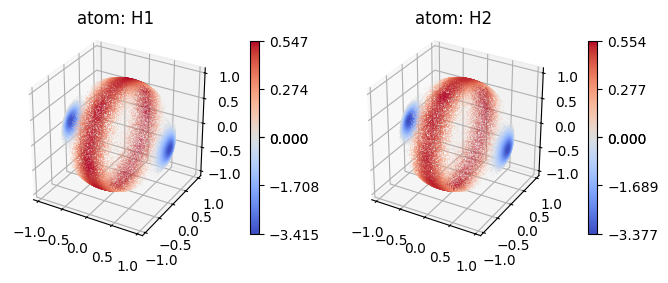

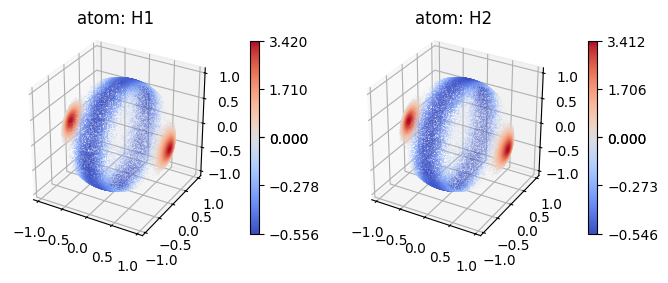

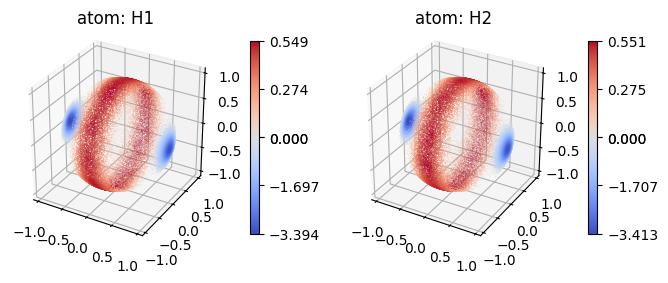

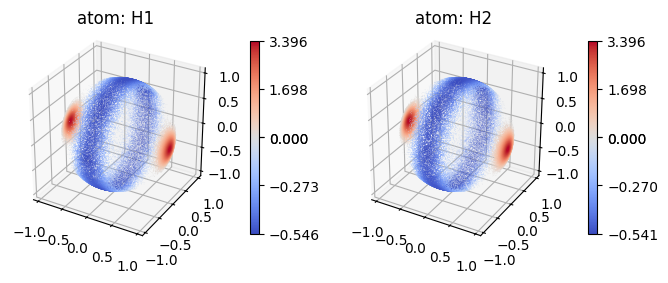

In [15]:
for sym in ("B1", "B2"):
    print(f"Plot rotational spin-density for state symmetry {sym}")

    for istate in range(len(spin_dens[sym, sym])):
        ind, *_ = hyper_state_ind[f][sym][istate]
        e = hyper_enr[f][sym][ind]
        print(f"state index: {istate}, energy: {e}")

        fig = plt.figure(figsize=(8, 5))
        axs = [
            fig.add_subplot(1, 2, 1, projection="3d"),
            fig.add_subplot(1, 2, 2, projection="3d"),
        ]
        for ax in axs:
            ax.set_box_aspect(aspect=(1, 1, 1))
            ax.axes.set_xlim3d(left=-1.1, right=1.1)
            ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
            ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

        for i, (xyz, ax) in enumerate(zip(atom_xyz[1:], axs)):  # skip S atom
            dz = spin_dens[(sym, sym)][
                istate, istate, :, :, :, -1, i
            ]  # Z-component of spin-density
            xyz_samples, weights, signs = monte_carlo_distr(
                2000000, alpha, beta, gamma, dz, xyz
            )

            weights = np.real(weights * signs)

            x, y, z = xyz_samples.T
            sc = ax.scatter(
                z,
                x,
                y,
                c=weights,
                s=1,
                edgecolor="none",
                marker=".",
                cmap="coolwarm",
                norm=mcolors.TwoSlopeNorm(
                    vmin=np.min(weights), vcenter=0, vmax=np.max(weights)
                ),
            )
            ax.view_init(elev=30, azim=-60)

            cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
            cbar_ticks = np.concatenate(
                (np.linspace(np.min(weights), 0, 3), np.linspace(0, np.max(weights), 3))
            )
            cbar.set_ticks(cbar_ticks)

            ax.set_title(f"atom: {atom_label[i+1]}")

        plt.savefig(f"h2s_mc_spindens_f{f}_m{m_f}_sym{sym}_ind{istate}.png", dpi=300)
        # plt.show()

Stark effect for cluster states.

In [122]:
print(f"Compute Stark energies for F = {f}, m_F = {m_f}")

# dipole matrix elements in hyperfine basis
dip_me, dip_qua = dipole_xy2(
    {f: hyper_qua_block[f]}, hyper_vec, rovib_dipole, m_val=m_f
)

# diagonal hyperfine field-free Hamiltonian
h0 = np.diag([hyper_enr[float(f)][sym][int(ind)] for (f, m, sym, ind) in dip_qua])

print("Hamiltonian size:", h0.shape)

# field_V_per_cm = (0, 2, 4, 6, 8, 10, 100, 200, 300)
field_V_per_cm = np.linspace(0, 10, num=11)
field = np.array(field_V_per_cm) * 100 # field in V/m

hyper_enr_stark = []
hyper_vec_stark = []

for fz in field:
    print(f"solve for Fz = {round(fz, 2)}")
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)

    hyper_enr_stark.append(e)
    hyper_vec_stark.append(v)

hyper_enr_stark = np.array(hyper_enr_stark)
hyper_vec_stark = np.array(hyper_vec_stark)

Compute Stark energies for F = 60.0, m_F = 60.0
Hamiltonian size: (6000, 6000)
solve for Fz = 0.0
solve for Fz = 100.0
solve for Fz = 200.0
solve for Fz = 300.0
solve for Fz = 400.0
solve for Fz = 500.0
solve for Fz = 600.0
solve for Fz = 700.0
solve for Fz = 800.0
solve for Fz = 900.0
solve for Fz = 1000.0


In [135]:
field_ind = 3

# indices of rotational cluster states in dipole-coupled basis, `hyper_state_ind_stark`
hyper_state_ind_stark = []
for (
    istate,
    i,
) in enumerate(np.argmax(np.abs(hyper_vec_stark[field_ind]) ** 2, axis=0)):
    f, m, sym, ind = dip_qua[i]
    if int(ind) in [ind_ for (ind_, *_) in hyper_state_ind[float(f)][sym]]:
        hyper_state_ind_stark.append(istate)
print("indices of hyperfine cluster states:", hyper_state_ind_stark)

# indices of states in dipole-coupled basis that have significant
# contributions to rotational cluster states, `nz_vec_stark_ind`
vec_thresh = 1e-3
nz_vec_stark_ind = np.unique(
    np.hstack(
        [
            np.where(np.abs(hyper_vec_stark[field_ind][:, i]) > vec_thresh)[0]
            for i in hyper_state_ind_stark
        ]
    )
)
print(
    "indices of states with significant contributions to cluster states:",
    nz_vec_stark_ind,
)

qua = dip_qua[nz_vec_stark_ind]
print("... corresponding quanta (f,m_f,sym,ind):\n", qua)

# corresponding eigenvectors
vec = np.array(
    [hyper_vec_stark[field_ind][nz_vec_stark_ind, i] for i in hyper_state_ind_stark]
)

for i, v in enumerate(vec.T):
    ind = [i_ for i_, v_ in enumerate(v) if np.abs(v_) / np.max(np.abs(v)) > 1e-2]
    out_str = [
        f"hy_state[{qua[i_][-2]},{qua[i_][-1]}] * {np.round(v[i_], 4)}" for i_ in ind
    ]
    print(" + ".join(out_str))

indices of hyperfine cluster states: [3653, 3654, 3655, 3656]
indices of states with significant contributions to cluster states: [1802 1803 4851 4852]
... corresponding quanta (f,m_f,sym,ind):
 [['60.0' '60.0' 'B1' '1802']
 ['60.0' '60.0' 'B1' '1803']
 ['60.0' '60.0' 'B2' '1851']
 ['60.0' '60.0' 'B2' '1852']]
hy_state[B1,1802] * (0.7072-0j) + hy_state[B1,1803] * (-0.707+0j)
hy_state[B2,1851] * (0.7072-0j) + hy_state[B2,1852] * (-0.707+0j)
hy_state[B1,1802] * -0.707j + hy_state[B1,1803] * (-0-0.7072j)
hy_state[B2,1851] * (-0-0.707j) + hy_state[B2,1852] * -0.7072j


In [136]:
# indices of states that have significant contributions to rotational cluster states: nz_vec_stark_ind

vec_thresh = 1e-3
nz_vec_stark_ind = np.unique(
    np.hstack(
        [
            np.where(np.abs(hyper_vec_stark[field_ind][:, i]) > vec_thresh)[0]
            for i in hyper_state_ind_stark
        ]
    )
)

print(nz_vec_stark_ind)

spin_dens_stark = []
for f1, m1, sym1, ind1 in dip_qua[nz_vec_stark_ind]:
    i1 = np.where(
        np.array([ind_ for (ind_, *_) in hyper_state_ind[float(f1)][sym1]]) == int(ind1)
    )[0]
    assert (
        len(i1) == 1
    ), f"state index {ind1} appears more than once in `hyper_state_ind` for F = {f1}, sym = {sym1} "
    i1 = i1[0]

    spin_dens_stark_ = []
    for f2, m2, sym2, ind2 in dip_qua[nz_vec_stark_ind]:
        i2 = np.where(
            np.array([ind_ for (ind_, *_) in hyper_state_ind[float(f2)][sym2]])
            == int(ind2)
        )[0]
        assert (
            len(i2) == 1
        ), f"state index {ind2} appears more than once in `hyper_state_ind` for F = {f2}, sym = {sym2} "
        i2 = i2[0]
        spin_dens_stark_.append(spin_dens[(sym1, sym2)][i1, i2])
    spin_dens_stark.append(spin_dens_stark_)

vec = np.array(
    [hyper_vec_stark[field_ind][nz_vec_stark_ind, i] for i in hyper_state_ind_stark]
)

spin_dens_stark = np.einsum(
    "ki,ij...,lj->kl...",
    np.conj(vec),
    np.array(spin_dens_stark),
    vec,
    optimize="optimal",
)

[1802 1803 4851 4852]


Plot rotational spin-density for 
state index: 0, energy: 32309.795244493514
state index: 1, energy: 32309.795299239533
state index: 2, energy: 32309.795318812656
state index: 3, energy: 32309.795373558798


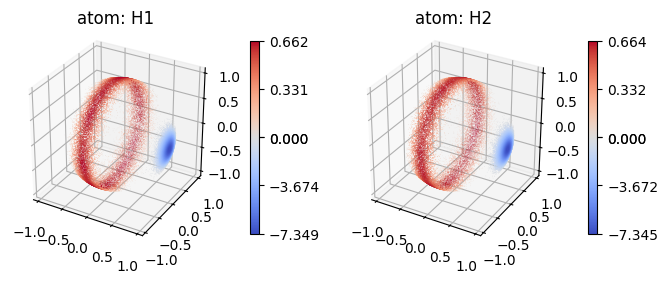

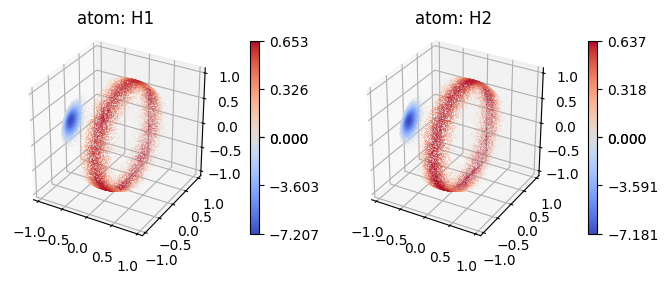

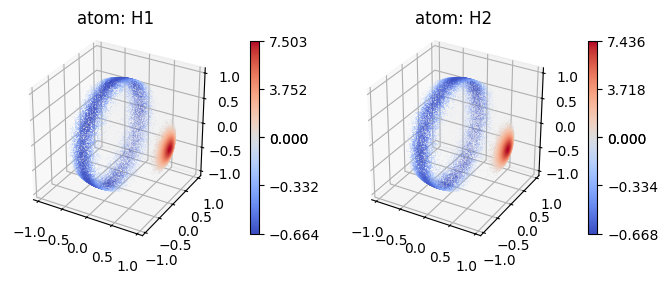

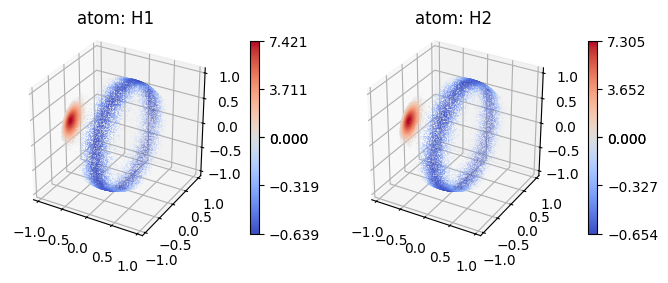

In [137]:
print(f"Plot rotational spin-density for ")

for istate in range(len(spin_dens_stark)):
    ind = hyper_state_ind_stark[istate]
    e = hyper_enr_stark[field_ind][ind]
    print(f"state index: {istate}, energy: {e}")

    fig = plt.figure(figsize=(8, 5))
    axs = [
        fig.add_subplot(1, 2, 1, projection="3d"),
        fig.add_subplot(1, 2, 2, projection="3d"),
    ]
    for ax in axs:
        ax.set_box_aspect(aspect=(1, 1, 1))
        ax.axes.set_xlim3d(left=-1.1, right=1.1)
        ax.axes.set_ylim3d(bottom=-1.1, top=1.1)
        ax.axes.set_zlim3d(bottom=-1.1, top=1.1)

    for i, (xyz, ax) in enumerate(zip(atom_xyz[1:], axs)):  # skip S atom
        dz = spin_dens_stark[istate, istate, :, :, :, -1, i]
        xyz_samples, weights, signs = monte_carlo_distr(
            2000000, alpha, beta, gamma, dz, xyz
        )

        weights = np.real(weights * signs)

        x, y, z = xyz_samples.T
        sc = ax.scatter(
            z,
            x,
            y,
            c=weights,
            s=1,
            edgecolor="none",
            marker=".",
            cmap="coolwarm",
            norm=mcolors.TwoSlopeNorm(
                vmin=np.min(weights), vcenter=0, vmax=np.max(weights)
            ),
        )
        ax.view_init(elev=30, azim=-60)

        cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
        cbar_ticks = np.concatenate(
            (np.linspace(np.min(weights), 0, 3), np.linspace(0, np.max(weights), 3))
        )
        cbar.set_ticks(cbar_ticks)

        ax.set_title(f"atom: {atom_label[i+1]}")

    plt.savefig(
        f"h2s_mc_spindens_field{round(field[field_ind], 3)}_f{f}_m{m_f}_sym{sym}_ind{istate}.png",
        dpi=300,
    )
    # plt.show()

32309.795271860992


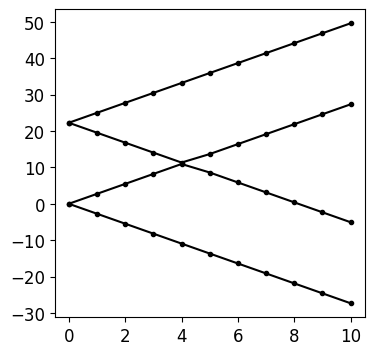

In [131]:
from scipy import interpolate

ind = hyper_state_ind_stark
e = np.array([e_[ind] for e_ in hyper_enr_stark])
e0 = np.min(e[0])
e = (e - e0) / (KHZ_TO_INVCM * 100)  # energies in MHz relative to e0
print(e0)
func = interpolate.interp1d(field, e, axis=0, kind='linear')

fig, ax = plt.subplots(figsize=(4, 4))

x = np.linspace(0, 1000, 100)
ax.plot(x / 100, func(x), "k-")
ax.plot(field / 100, e, "k.")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f"h2s_stark_f{f}_m{m_f}.png", dpi=300)
# plt.show()